Consider as a baseline scenario one with $M = 64$, $K = 13$ and $N = 2$; distance-based UE-AP attachment and random channel allocation. Run Monte Carlo simulations to evaluate the three UE-AP attachment and channel allocation algorithms above and compare it to the baseline case. Create a table comparing the KPIs. See how much capacity you can recover in comparison with the
baseline case.


In [235]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(12)

In [236]:
# Função que transforma Linear para dB
def lin2db(x):
    return 10 * np.log10(x)

# Função que transforma dB para Linear
def db2lin(x):
    return 10 ** (x / 10)

# Função que transforma Linear para dBm
def lin2dbm(x):
    return 10 * np.log10(x) + 30

# Função que transforma dBm para Linear
def dbm2lin(x):
    return 10 ** ((x - 30) / 10)

In [237]:
# Função que define os eixos x e y da CDF
def cdf(dados):
    '''Função que calcula a Cumulative Distribution Function (CDF) de um conjunto de dados.
    Parâmetros:
    dados: array. Conjunto de dados.
    Retorno:
    x: array. Dados ordenados.
    y: array. Probabilidade acumulada de cada dado.'''

    x = np.sort(dados)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

In [238]:
# Função que gera as coordenadas dos APs
def distribuir_APs(num_aps, area):
    '''Distributes Access Points (APs) evenly within a square area.
    
    Parameters:
    num_aps (int): The number of APs to distribute. Must be a perfect square.
    area (int): The length of the side of the square area in which to distribute the APs.
    
    Returns:
    np.array: An array of coordinates for the APs, or None if num_aps is not a perfect square.'''
    
    if num_aps not in [1, 4, 9, 16, 25, 36, 49, 64, 100]:
        return None

    tamanho_quadrado = area
    lado_quadrado = int(np.sqrt(num_aps))

    tamanho_celula = tamanho_quadrado // lado_quadrado

    # Criar coordenadas usando meshgrid
    x, y = np.meshgrid(np.arange(0.5 * tamanho_celula, tamanho_quadrado, tamanho_celula),
                      np.arange(0.5 * tamanho_celula, tamanho_quadrado, tamanho_celula))

    coordenadas_APs = np.column_stack((x.ravel(), y.ravel()))

    return coordenadas_APs

In [239]:
# Função que gera a distância entre a UE e a AP
def dAPUE(x_coord, y_coord, ap_coord, d_reference=1):
  '''Calculate the Euclidean distance between a user equipment (UE) and an access point (AP).
    
    Parameters:
    ue_coords (tuple): A tuple (x_coord, y_coord) representing the coordinates of the UE.
    ap_coords (np.array): An array containing the coordinates of the APs.
    
    Returns:
    float: The Euclidean distance between the UE and the AP. If the euclidean distance is less than 1, return 1.
  '''
  dAPUE = np.linalg.norm(np.array([x_coord, y_coord]) - ap_coord)
  if dAPUE < d_reference:
    return d_reference
  else:
    return dAPUE

In [240]:
#Função que define o shadowing para cada usuário
def find_shadowing(standard_shadow, ues, aps):
    '''Generate a shadowing value for a user.

    Parameters:
    standard_shadow (float): The standard deviation of the shadowing values.
    ues (int): The number of user equipment (UE) in the simulation.
    aps (int): The number of access points (APs) in the

    Returns:
    np.array: A 2D array of shadowing values for each UE and AP.
    '''

    shadowing = np.random.lognormal(0, standard_shadow, (ues, aps))

    return shadowing 

In [241]:
def find_fastfading(standard_fading, ues, aps, channels):
    '''Função que calcula o fast fading para um dado usuário.
    
    Parâmetros:
    standard_fading (float): O desvio padrão da distribuição normal.
    ues (int): O número de usuários.
    aps (int): O número de pontos de acesso.
    channels (int): O número de canais.
    
    Retorna:
    np.array: Um array 3D com os valores de fast fading para cada usuário, ponto de acesso e canal.
    '''

    fast_fading = np.sqrt( (standard_fading * np.random.randn(ues, aps, channels))**2 + (standard_fading * np.random.randn(ues, aps, channels))**2 )

    return fast_fading

In [242]:
def find_pathgain(dist, shadowing, fastfading):
    ambiente_const = 1e-4
    pathloss_const = 4

    # Número de canais
    num_channels = fastfading.shape[2]

    # Expandindo o shadowing e o dist para ter a mesma forma que o fastfading
    shadowing_expanded = np.repeat(shadowing[:, :, np.newaxis], num_channels, axis=2)  # Agora tem forma (ues, aps, num_channels)
    dist_expanded = np.repeat((dist ** pathloss_const)[:, :, np.newaxis], num_channels, axis=2)  # Agora tem forma (ues, aps, num_channels)

    # Calculando o path gain
    path_gain_result = (shadowing_expanded * (ambiente_const / dist_expanded)) * (fastfading ** 2)

    return path_gain_result


In [243]:
def ue_channel_maxpath(shadowing, fastfading, distance_APUE):
    '''
    Lembrando que [ue, aps, channels] é a dimensão do path_gain.
    Função que calcula o canal com maior path gain para cada usuário.
    
    Parâmetros:
    distance_APUE (np.array): Um array 2D com as distâncias entre cada usuário e ponto de acesso.
    shadowing (np.array): Um array 2D com os valores de shadowing para cada usuário e ponto de acesso.
    fastfading (np.array): Um array 3D com os valores de fast fading para cada usuário, ponto de acesso e canal.
    
    Retorna:
    np.array: Um array 3D com os valores de path gain para cada usuário, ponto de acesso e canal, sendo que apenas o canal com maior path gain é mantido.
    '''

    path_gain = find_pathgain(distance_APUE, shadowing, fastfading)

    for ue in range(path_gain.shape[0]):
        # Achando o canal com maior path_gain para cada AP do UE atual
        index_max = np.argmax(path_gain[ue, :, :], axis=1)

        # Mantendo apenas o canal com maior path_gain
        for ap in range(path_gain.shape[1]):
            for channel in range(path_gain.shape[2]):
                if channel != index_max[ap]:
                    path_gain[ue, ap, channel] = 0

    return path_gain


In [244]:
def ue_channel_maxpath_realoc(shadowing, fastfading, distance_APUE):
    '''
    Lembrando que [ue, aps, channels] é a dimensão do path_gain.
    Função que calcula o canal com maior path gain para cada usuário e realoca o usuário caso tenha mais de um usuário alocado na mesma AP e no mesmo canal.
    
    Parâmetros:
    distance_APUE (np.array): Um array 2D com as distâncias entre cada usuário e ponto de acesso.
    shadowing (np.array): Um array 2D com os valores de shadowing para cada usuário e ponto de acesso.
    fastfading (np.array): Um array 3D com os valores de fast fading para cada usuário, ponto de acesso e canal.
    
    Retorna:
    np.array: Um array 3D com os valores de path gain para cada usuário, ponto de acesso e canal, sendo que apenas o canal com maior path gain é mantido, e caso tenha mais de um usuário alocado na mesma AP e no mesmo canal, o usuário com menor path gain é realocado para o canal com menor path gain.
    '''
    # Fazemos primeiramente a alocação de canais inicial 
    path_gain = find_pathgain(distance_APUE, shadowing, fastfading)
    for ue in range(path_gain.shape[0]):
        # Achando o canal com maior path_gain para cada AP do UE atual
        index_max = np.argmax(path_gain[ue, :, :], axis=1)

        # Mantendo apenas o canal com maior path_gain
        for ap in range(path_gain.shape[1]):
            for channel in range(path_gain.shape[2]):
                if channel != index_max[ap]:
                    path_gain[ue, ap, channel] = 0
    
    # Verificar se há mais de um usuário alocado na mesma AP e no mesmo canal
    for ap in range(path_gain.shape[1]):
        for channel in range(path_gain.shape[2]):

            ues_same_channel = np.where(path_gain[:, ap, channel] != 0)[0] # Pega os usuários que estão no mesmo canal

            if len(ues_same_channel) > 1:
                # Realocação se houver mais de um usuário no mesmo AP e canal
                for ue_conflict in ues_same_channel:
                    vacant_channel = np.where(path_gain[ue_conflict, ap, :] == 0)[0] # Pega os canais vazios para o AP

                    if len(vacant_channel) > 0: # Se tiver algum canal vazio
                        path_min = np.argmin(path_gain[ue_conflict, ap, vacant_channel]) # Pega o canal com menor path gain
                        selected_channel = vacant_channel[path_min]

                        # Realoca o usuário para o canal com menor path gain
                        path_gain[ue_conflict, ap, selected_channel] = path_gain[ue_conflict, ap, channel]

                        # Zera o canal antigo
                        path_gain[ue_conflict, ap, channel] = 0

    return path_gain


In [245]:
def ue_channel_partialortho(shadowing, fastfading, distance_APUE):
    '''
    Lembrando que [ue, aps, channels] é a dimensão do path_gain.
    Função que faz a alocação de recurso usando o algoritmo de partial orthogonalization, impedindo de ter mais de um usuário no mesmo Canal-AP que o outro usuário.
    
    Parâmetros:
    distance_APUE (np.array): Um array 2D com as distâncias entre cada usuário e ponto de acesso.
    shadowing (np.array): Um array 2D com os valores de shadowing para cada usuário e ponto de acesso.
    fastfading (np.array): Um array 3D com os valores de fast fading para cada usuário, ponto de acesso e canal.
    
    Retorna:
    np.array: Um array 3D com os valores de path gain de cada usuário, onde o algoritmo impede que tenha mais de um usuário no mesmo Canal-AP.
    '''

    path_gain = find_pathgain(distance_APUE, shadowing, fastfading)

    path_gain_ortho = np.zeros_like(path_gain)
    # Fazendo uma máscara booleana para definir quais combinações eu posso utilizar
    disp = np.ones((path_gain.shape[1], path_gain.shape[2]), dtype=bool)

    # Alocando agora cada UE para o melhor canal possível disponível
    for ue in range(path_gain.shape[0]):
        higher_gain = -np.inf  # Garantindo que qualquer ganho será maior que -inf
        best_comb = None

        for ap in range(path_gain.shape[1]):
            for channel in range(path_gain.shape[2]):
                if disp[ap, channel]:  # Se a combinação está disponível
                    if path_gain[ue, ap, channel] > higher_gain:
                        higher_gain = path_gain[ue, ap, channel]
                        best_comb = (ap, channel)

        # Alocando o usuário para o melhor canal possível
        if best_comb:
            selected_ap, selected_channel = best_comb
            path_gain_ortho[ue, selected_ap, selected_channel] = path_gain[ue, selected_ap, selected_channel]

            # Bloqueando as combinações que não podem ser utilizadas
            disp[selected_ap, selected_channel] = False

    return path_gain_ortho


In [246]:
def ue_channel_random(shadowing, fastfading, distance_APUE):

    path_gain = find_pathgain(distance_APUE, shadowing, fastfading)

    # Garantindo que temos mais de um canal:
    if path_gain.shape[0] > 1:
        for ues in range(path_gain.shape[1]):
            channel = np.random.randint(0, path_gain.shape[0])

            for aps in range(path_gain.shape[2]):
                for channels in range(path_gain.shape[0]):
                    if channels != channel:
                        path_gain[channels, ues, aps] = 0

    else:
        pass

    return path_gain


In [247]:
def calculate_sinr(banda, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, p_t, rrm_index, area):
    '''Função que calcula a SINR para múltiplos UEs e APs em diferentes canais.

    i-th UE, j-th AP, c-th channel
    
    Lembrando que [ue, aps, channels] é a dimensão da matriz path_gain. 

    Parâmetros:
    banda (float): Largura de banda total.
    K_0 (float): Constante de ruído.
    aps (int): Número de APs.
    ues (int): Número de UEs.
    channels (int): Número de canais.
    sigma_shadowing (float): Desvio padrão para o shadowing.
    sigma_fastfading (float): Desvio padrão para o fast fading.
    p_t (float): Potência de transmissão.
    rrm_index (int): Índice para o tipo de algoritmo de alocação de recursos.
    area (float): Área de distribuição dos APs.
    
    Retorna:
    np.array: O valor do SINR para cada UE.
    '''
    # Inicializações
    x_coord, y_coord, aps_position = np.zeros(ues), np.zeros(ues), distribuir_APs(aps, area)
    dist = np.zeros((ues, aps))
    shadowing = find_shadowing(sigma_shadowing, ues, aps)
    fastfading = find_fastfading(sigma_fastfading, ues, aps, channels)
    power_trans = np.ones(ues) * p_t
    power_noise = np.ones(ues) * (K_0 * banda / channels)

    # Coordenadas dos UEs
    for ue_index in range(ues):
        x_coord[ue_index] = np.random.randint(0, area)
        y_coord[ue_index] = np.random.randint(0, area)

    # Distância entre UEs e APs
    for ue_index in range(ues):
        for ap_index in range(aps):
            dist[ue_index][ap_index] = dAPUE(x_coord[ue_index], y_coord[ue_index], aps_position[ap_index])

    # Cálculo do path gain
    if rrm_index == 0:
        path_gain = ue_channel_maxpath(shadowing, fastfading, dist)
    elif rrm_index == 1:
        path_gain = ue_channel_maxpath_realoc(shadowing, fastfading, dist)
    elif rrm_index == 2:
        path_gain = ue_channel_partialortho(shadowing, fastfading, dist)
    elif rrm_index == 3:
        path_gain = ue_channel_random(shadowing, fastfading, dist)

    # Cálculo do SINR
    sinr_total = np.zeros(path_gain.shape)
    sinr_ue = np.zeros(path_gain.shape[0])

    for ue_index in range(path_gain.shape[0]):
        for ap_index in range(path_gain.shape[1]):
            for channel_index in range(path_gain.shape[2]):
                # Calculando a potência recebida para o canal atual
                power_received = np.abs(path_gain[ue_index, ap_index, channel_index]) * power_trans[ue_index]
    
                # Calculando a interferência no mesmo canal
                interference_sum = 0
                for other_ue_index in range(path_gain.shape[0]):
                    if other_ue_index != ue_index:  # Se não for o mesmo usuário
                        interference_sum += np.abs(path_gain[other_ue_index, ap_index, channel_index]) * power_trans[other_ue_index]

                # Cálculo da SINR para o canal, UE e AP atuais
                sinr_total[ue_index, ap_index, channel_index] = power_received / (interference_sum + power_noise[ue_index])

    # Selecionar o maior valor de SINR para cada UE
    for ue_index in range(sinr_total.shape[0]):
        sinr_ue[ue_index] = np.max(sinr_total[ue_index, :, :])

    return sinr_ue


In [248]:
def find_capacity(sinr, banda, channels):
    '''Função que calcula a capacidade de um dado canal.
    
    Parâmetros:
    sinr (list): A relação sinal ruído mais interferência.
    banda (int): A largura de banda do canal.    
    channels (int): O número de canais.
    Retorna:
    list: A capacidade do canal.'''

    banda_canal = banda / channels  
    
    capacity = banda_canal * np.log2(1 + sinr)
    
    return capacity

In [249]:
bandwidth , transmit_power, d_min, K_0 = 100e6, 1, 1, 1e-20 # Em MHz, mW, metros, mW/Hz respectivamente
aps, ues, channels = 64, 13, 2
area = 1000
sigma_shadowing = 2
sigma_fastfading = 1/np.sqrt(2)
maxpath, maxpath_plus_realoc, partial_ortho, random = 0, 1, 2, 3 # Maxpath, Maxpath + Realoc, Partial orthogonalization, Random


In [250]:
capacity_acum_dist = np.array([])
capacity_acum_shad = np.array([])
capacity_acum_fast = np.array([])
capacity_acum_random = np.array([])

sinr_acum_dist = np.array([])
sinr_acum_shad = np.array([])
sinr_acum_fast = np.array([])
sinr_acum_random = np.array([]) 

for iterations in range (1000):
    sinr_dist = calculate_sinr(bandwidth, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, transmit_power, maxpath, area)
    sinr_shad = calculate_sinr(bandwidth, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, transmit_power, maxpath_plus_realoc, area)
    sinr_fast = calculate_sinr(bandwidth, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, transmit_power, partial_ortho, area)
    #sinr_random = calculate_sinr(bandwidth, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, transmit_power, random, area)


    capacity_dist = find_capacity(sinr_dist, bandwidth, channels)
    capacity_shad = find_capacity(sinr_shad, bandwidth, channels)
    capacity_fast = find_capacity(sinr_fast, bandwidth, channels)
    #capacity_random = find_capacity(sinr_random, bandwidth, channels)

    sinr_acum_dist = np.append(sinr_acum_dist, sinr_dist)
    sinr_acum_shad = np.append(sinr_acum_shad, sinr_shad)
    sinr_acum_fast = np.append(sinr_acum_fast, sinr_fast)
    #sinr_acum_random = np.append(sinr_acum_random, sinr_random)

    capacity_acum_dist = np.append(capacity_acum_dist, capacity_dist)
    capacity_acum_shad = np.append(capacity_acum_shad, capacity_shad)
    capacity_acum_fast = np.append(capacity_acum_fast, capacity_fast)
    #capacity_acum_random = np.append(capacity_acum_random, capacity_random)


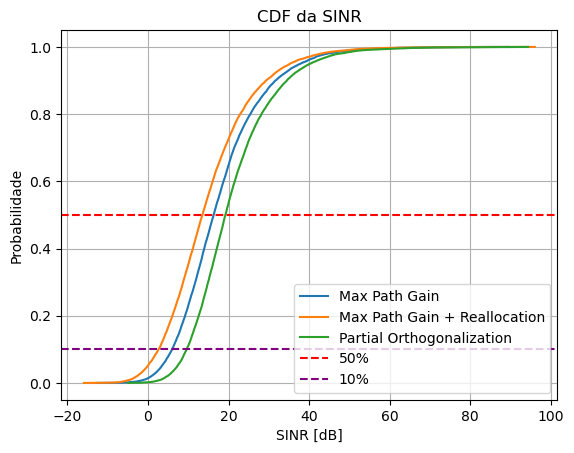

In [251]:
cdf_sinr_dist = cdf(lin2db(sinr_acum_dist))
cdf_sinr_shad = cdf(lin2db(sinr_acum_shad))
cdf_sinr_fast = cdf(lin2db(sinr_acum_fast))
cdf_sinr_random = cdf(lin2db(sinr_acum_random))

cdf_capacity_dist = cdf(capacity_acum_dist)
cdf_capacity_shad = cdf(capacity_acum_shad)
cdf_capacity_fast = cdf(capacity_acum_fast)
cdf_capacity_random = cdf(capacity_acum_random)

plt.figure()
#plt.plot(cdf_sinr_random[0], cdf_sinr_random[1], label='Random')
plt.plot(cdf_sinr_dist[0], cdf_sinr_dist[1], label='Max Path Gain')
plt.plot(cdf_sinr_shad[0], cdf_sinr_shad[1], label='Max Path Gain + Reallocation')
plt.plot(cdf_sinr_fast[0], cdf_sinr_fast[1], label='Partial Orthogonalization')
plt.title('CDF da SINR')
plt.xlabel('SINR [dB]')
plt.ylabel('Probabilidade')

plt.axhline(0.5, color='r', linestyle='--', label='50%')
plt.axhline(0.1, color='purple', linestyle='--', label='10%')

plt.legend()
plt.grid()

plt.savefig('Q3_SINR.pdf')
plt.show()


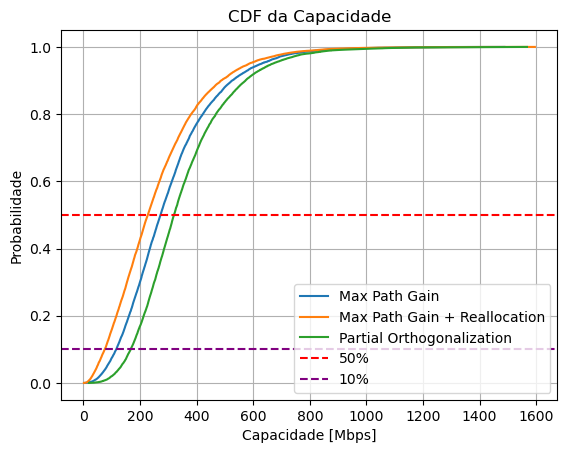

In [252]:
cdf_dist = cdf(capacity_acum_dist)
cdf_shad = cdf(capacity_acum_shad)
cdf_fast = cdf(capacity_acum_fast)
cdf_rand = cdf(capacity_acum_random)

# Plotando a CDF da Capacidade e deixando em Mbps
plt.figure()
#plt.plot(cdf_rand[0]/1e9, cdf_rand[1], label='Random')
plt.plot(cdf_dist[0]/1e6, cdf_dist[1], label='Max Path Gain')
plt.plot(cdf_shad[0]/1e6, cdf_shad[1], label='Max Path Gain + Reallocation')
plt.plot(cdf_fast[0]/1e6, cdf_fast[1], label='Partial Orthogonalization')
plt.title('CDF da Capacidade')
plt.xlabel('Capacidade [Mbps]')
plt.ylabel('Probabilidade')

plt.axhline(0.5, color='r', linestyle='--', label='50%')
plt.axhline(0.1, color='purple', linestyle='--', label='10%')

plt.legend()
plt.grid()
plt.savefig('Q3_Capacity.pdf')
plt.show()


